In [ ]:
### Package Installation ###
pip install perceval-quandela

In [1]:
from IPython import display
from collections import Counter
from tabulate import tabulate
from tqdm.auto import tqdm
import gzip
import pickle
import time

import sympy as sp
import random

import perceval as pcvl
import perceval.lib.symb as symb

n = 14 # Number of photons at the input
m = 60 # Number of modes
N = 2  # Number of samples

Unitary_60 = pcvl.Matrix.random_unitary(m) # Creates a random unitary of dimension 60

# Define a 2-mode unitary circuit that we can use to decompose the 60 mode unitary
mzi = (symb.BS() // (0, symb.PS(phi=pcvl.Parameter("φ_a")))
       // symb.BS() // (1, symb.PS(phi=pcvl.Parameter("φ_b"))))
pcvl.pdisplay(mzi)

In [2]:
# Decompose the unitary into a Reck's type circuit
Linear_Circuit_60 = pcvl.Circuit.decomposition(Unitary_60, mzi,
                                               phase_shifter_fn=symb.PS,
                                               shape="triangle")

# Sampling using CliffordClifford2017 backend
Sampling_Backend = pcvl.BackendFactory().get_backend("CliffordClifford2017")

# Select a random input
def Generating_Input(n, m, modes = None):
    "This function randomly chooses an input with n photons in m modes."
    if modes == None :
        modes = sorted(random.sample(range(m),n))
    state = "|"
    for i in range(m):
        state = state + "0"*(1 - (i in modes)) +"1"*(i in modes)+ ","*(i < m-1)
    return pcvl.BasicState(state + ">")

# Display input state
input_state = Generating_Input(n, m)
print("The input state: ", input_state)

The input state:  |0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1>


In [29]:
# Generate random bitstream of bitMax bits and save into file 'RandBits.txt'

bitMax = 100000; # We want to generate at least bitMax random bits
bitNum = 0; # Counter for bits generated

import time
start_time = time.time()

while bitNum <= bitMax:
    
    S1 = str(Sampling_Backend(Unitary_60).sample(pcvl.BasicState(input_state))) # Saves Sample 1
    S2 = str(Sampling_Backend(Unitary_60).sample(pcvl.BasicState(input_state))) # Saves Sample 2
    finalString = [] # Saves final string after von-Neuman post processing

    for x in range(2*m+1):
        if S1[x] == '|' or S1[x] == ',' or S1[x] =='>':
            pass
        else:
            # print(S1[x], S2[x])
            if (int(S1[x]) > 0 and int(S2[x]) > 0) or (int(S1[x]) == 0 and int(S2[x]) == 0):
                pass
            else:
                if int(S1[x]) > 0 and int(S2[x])==0:
                    finalString.append(0);
                else:
                    finalString.append(1);

    # Append the generated random number in ASCII to the end of a txt file
    # Will create file if it does not already exist in directory
    f = open('RandBits.txt', 'a')
    for x in range(len(finalString)):
        f.write(str(finalString[x]))
    f.close()
    
    bitNum += len(finalString)
    
print("%d bits / %s seconds" % (bitNum, time.time() - start_time))
print("= %d bits/sec" % (bitNum/(time.time() - start_time)))

100004 bits / 24.08885908126831 seconds
= 4151 bits/sec


In [30]:
# Read in 10 random bits at a time from the file, convert to decimal form
def readRANDfile():
    decNum = 0;
    f = open('RandBits.txt', 'r')
    for x in range(10):
        bit = int(f.read(1))
        decNum = decNum + 2**(5-1-x)*bit
    return decNum

# Returns a vector of N random numbers in range [lo,hi]
def RNG_GivenRange(lo,hi,N):
    # Create vector of random numbers in decimal form
    randVec = []
    max = 0
    for count in range(N):
        randNum = readRANDfile()
        if randNum > max:
            max = randNum
        randVec.append(randNum)

    # Normalize by max, map to the range given by lo to hi
    for count in range(N):
        randVec[count] = randVec[count]/max
        randVec[count] = randVec[count]*(hi-lo)
        randVec[count] = randVec[count]+lo
    return randVec

# Define function to integrate
def func(x):
    return np.cos(x)

# Random number generation by multiplying NumPy random number with boson random number
def bosonRNG(a,b,N):
    lo = 0; hi = 1;
    BOSONrandVec = RNG_GivenRange(lo,hi,N)
    DETrandVec = np.random.uniform(low=a, high=b, size=N)
    COMBOrandVec = []
    for count in range(len(DETrandVec)):
        COMBOrandVec.append(DETrandVec[count]*BOSONrandVec[count])
    return COMBOrandVec

In [31]:
# Monte Carlo integration
def mc_int(func, xlim, ylim, dx, dy, N):
    f = lambda v: func(x=v)
    
    # Number of times to average to increase accuracy
    num = 10
    
    I = 0
    for ii in range(num):
        # Generate random points
        Rx = bosonRNG(xlim[0],xlim[1],N)
        Ry = bosonRNG(ylim[0],ylim[1],N)
        
        # Count number of points between f(x) and the x-axis
        count = 0;
        for n in range(N-1):
            z = f(Rx[n])
            
            # Positive contributions
            if (Ry[n] <= z) and (Ry[n] >= 0):
                count = count + 1
                
            # Negative contributions
            elif (Ry[n] >= z) and (Ry[n] < 0):
                count = count - 1
                
        # Rescale
        I = count / N * dx * dy + I
        
    # Compute average
    I = I / num
    
    return I

Expected value = -1.088
Estimated value = -1.0888000000000002


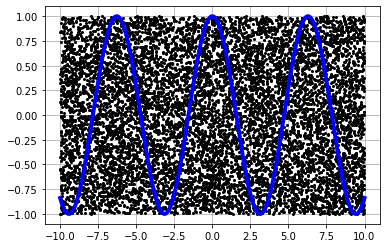

In [36]:
# Demonstration
import numpy as np
import matplotlib.pyplot as plt

N = 10000

xlim = [-10,10]
ylim = [-1,1]

dx = xlim[1] - xlim[0]
dy = ylim[1] - ylim[0]

I = mc_int(func, xlim, ylim, dx, dy, N)

# Visualization
x = np.linspace(xlim[0], xlim[1], N)
Rx = bosonRNG(xlim[0],xlim[1],N)
Ry = bosonRNG(ylim[0],ylim[1],N)

plt.plot(Rx, Ry, 'ko', markerfacecolor='black', markersize=2)
plt.plot(x, func(x), linewidth=4, color='blue')
plt.grid()

# Print integral
print("Expected value = -1.088")
print("Estimated value =", I)